# Hyper Parameter Optimization For LightGBM

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'LightGBM'

In [2]:
current_path = os.getcwd()
current_path

'/output/workspace/Band-gap-predict/SingleModels/LightGBM'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

## Model Train

### DFT Model

In [ ]:
# using grid search to find the best hyperparameters for the dft model
print(f"['DFT {MODEL_NAME}'] HP optimazation begin...")

# create a pipeline with a scaler and the LightGBM model
lgbm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm',  LGBMRegressor(objective='regression', metric='rmse', random_state=RANDOM_SEED,
            verbosity=0, n_jobs=-1))
])

# define the parameter grid for the LightGBM model(total 512 combinations)
param_grid = {
    'lgbm__n_estimators': [200, 500],
    'lgbm__max_depth': [-1, 5, 7, 9],
    'lgbm__learning_rate': [0.05, 0.1, 0.2, 0.3],
    'lgbm__reg_alpha': [0, 0.1],
    'lgbm__reg_lambda': [0, 0.1],
    'lgbm__subsample': [0.7, 1.0],
    'lgbm__colsample_bytree': [0.7, 1.0]
}

# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# n_iter=5, time=
# create a GridSearchCV object
# grid_search = GridSearchCV(
#     estimator=lgbm_pipe, 
#     param_grid=param_grid, 
#     scoring='neg_mean_squared_error', 
#     cv=kf, 
#     n_jobs=-1, 
#     verbose=1,
#     return_train_score=True)
grid_search = RandomizedSearchCV(estimator=lgbm_pipe, param_distributions=param_grid,
                n_iter=5, cv=kf, verbose=1, random_state=RANDOM_SEED, 
                scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
# fit the model to the training data
grid_search.fit(dft_train_X, dft_train_y)

In [ ]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_lgbm__learning_rate', 
                                 'param_lgbm__max_depth', 'param_lgbm__n_estimators', 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'dft_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': -1, 'n_estimators': 500}
Best Cross-Validation RMSE: 0.7211


,rank_test_score,param_learning_rate,param_max_depth,param_n_estimators,train_rmse,test_rmse
25,1,0.2,-1,500,0.433647,0.721079
31,2,0.2,8,500,0.442752,0.721604
17,3,0.1,-1,500,0.551170,0.738103
23,4,0.1,8,500,0.560997,0.739592
30,5,0.2,8,200,0.601591,0.757950


### Overfitting check

####################################################################################################
[DFT - LightGBM] Training LightGBM on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.4s
Model training completed!
[Train_error] Evaluating DFT LightGBM on DFT train set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


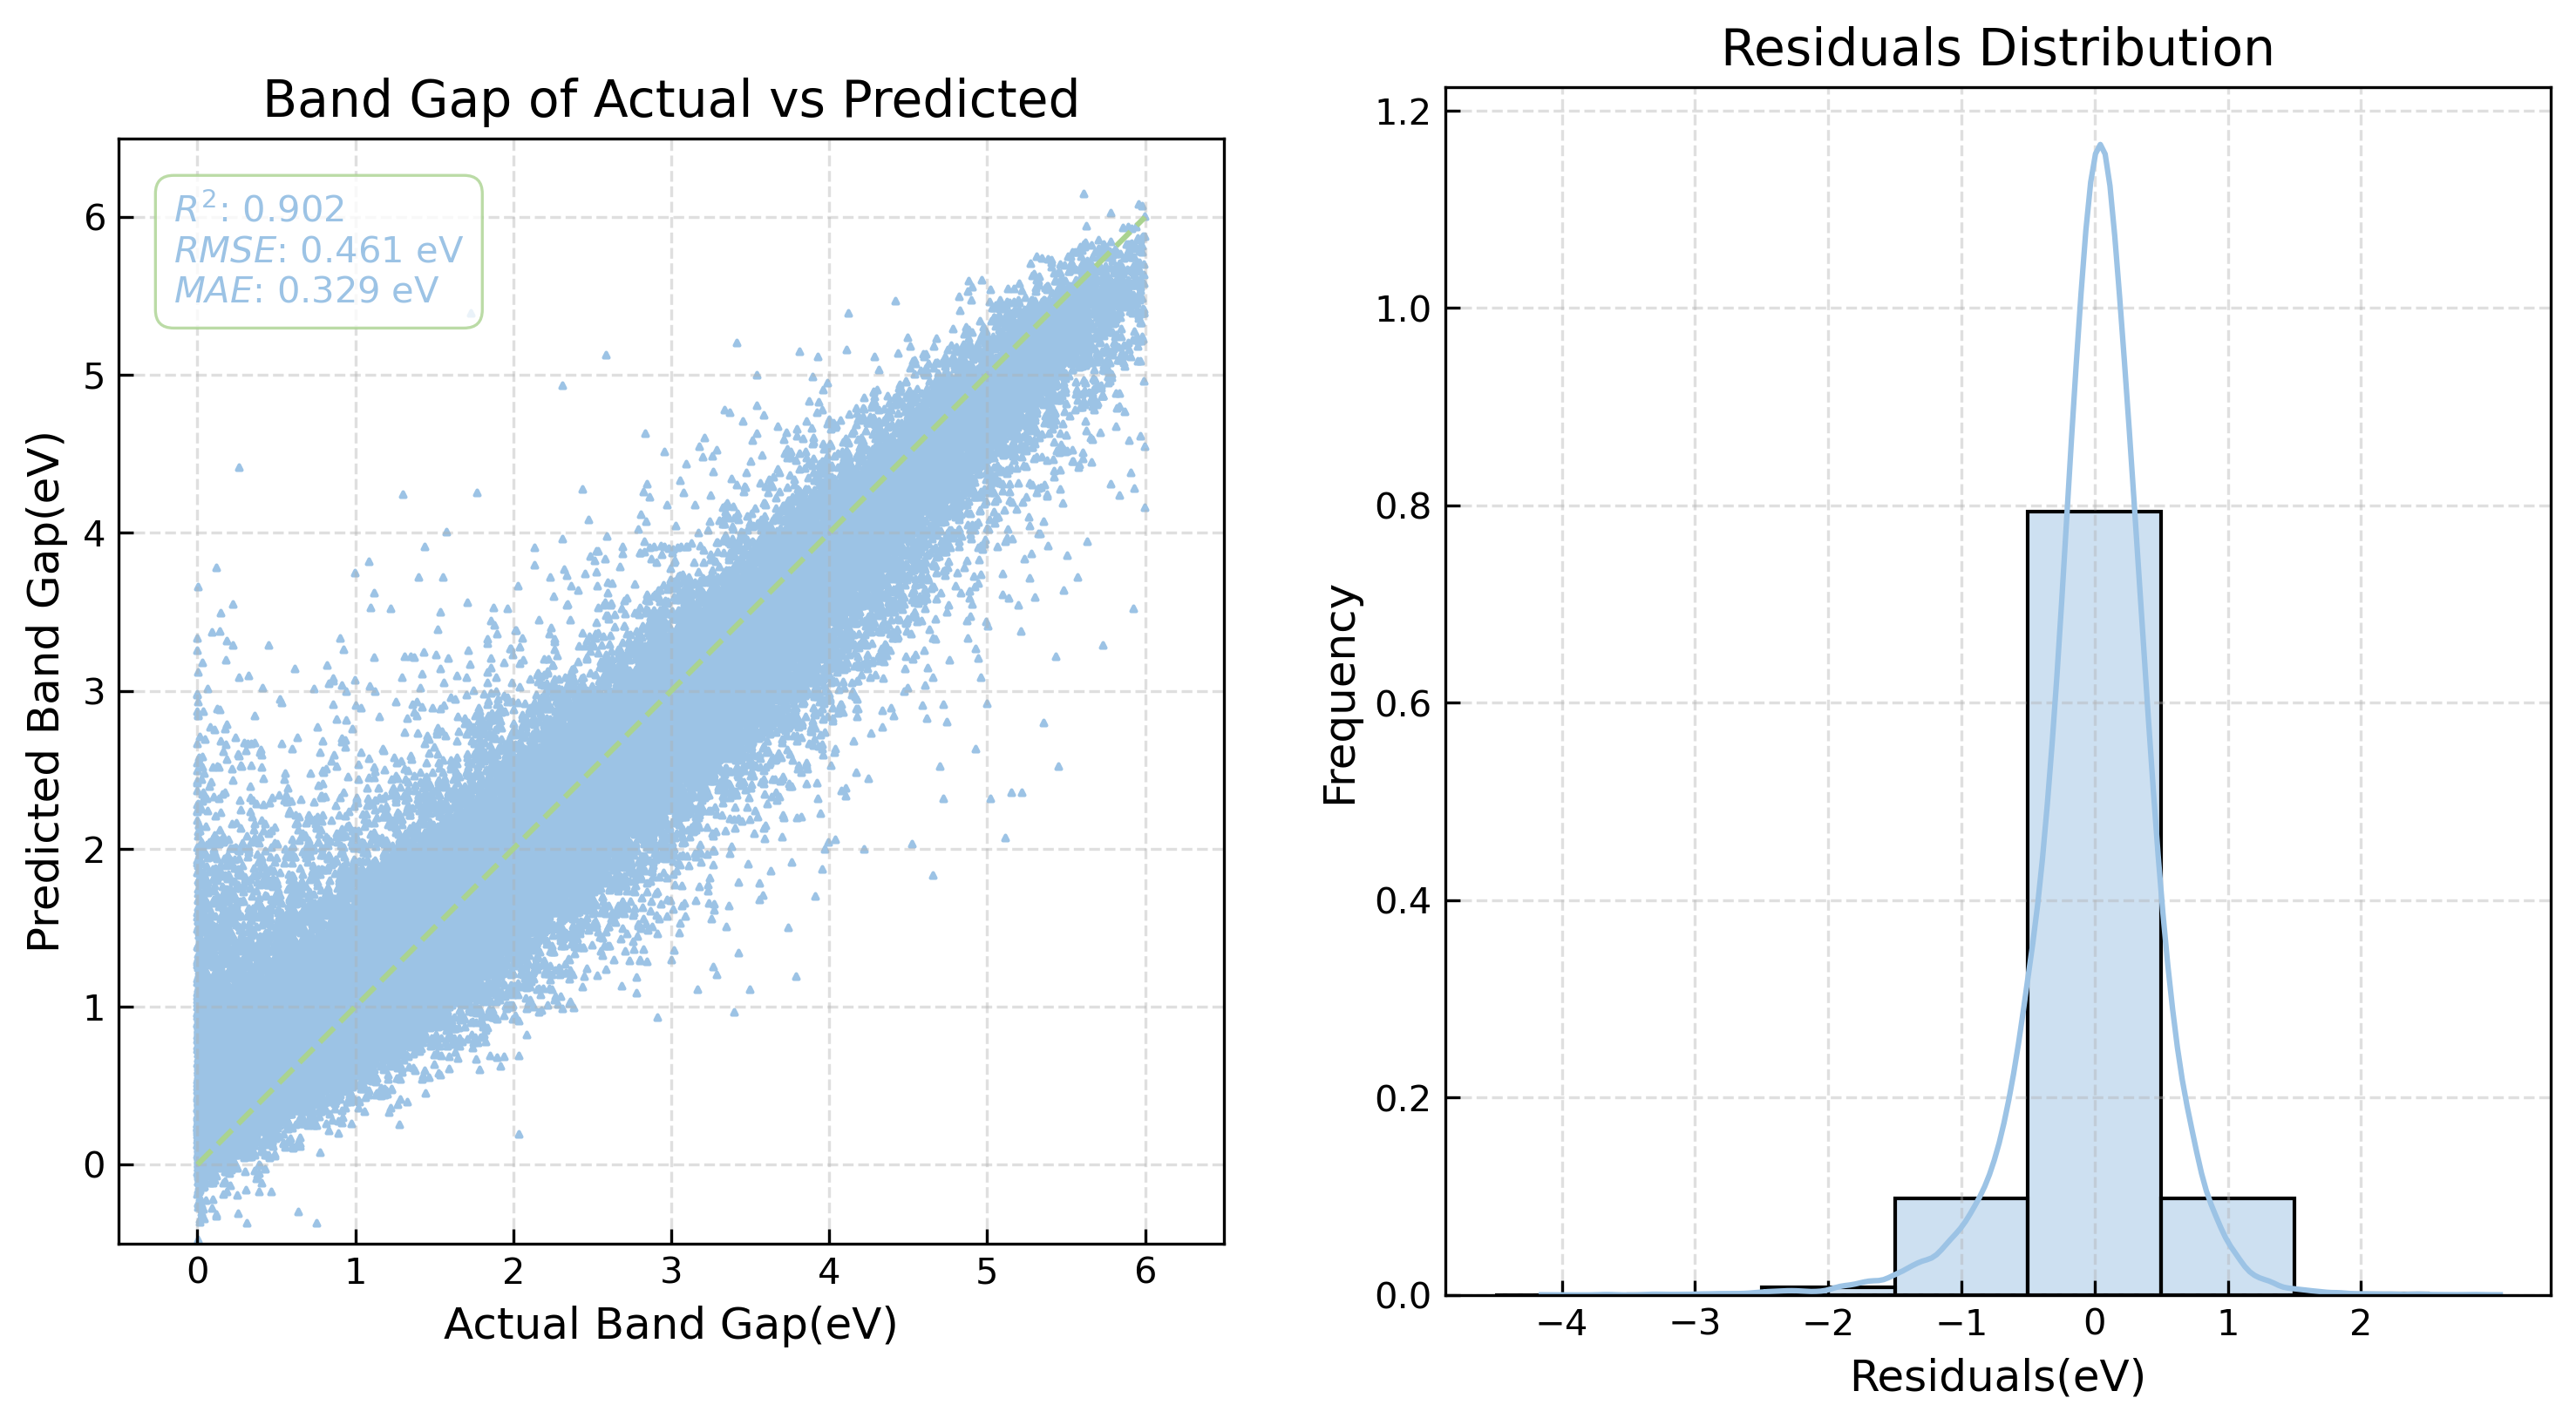


Model Evaluation Results:
Test set: R²: 0.9024 RMSE: 0.4612 MAE: 0.3292
[Test DFT -> DFT] Evaluating DFT LightGBM on DFT test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


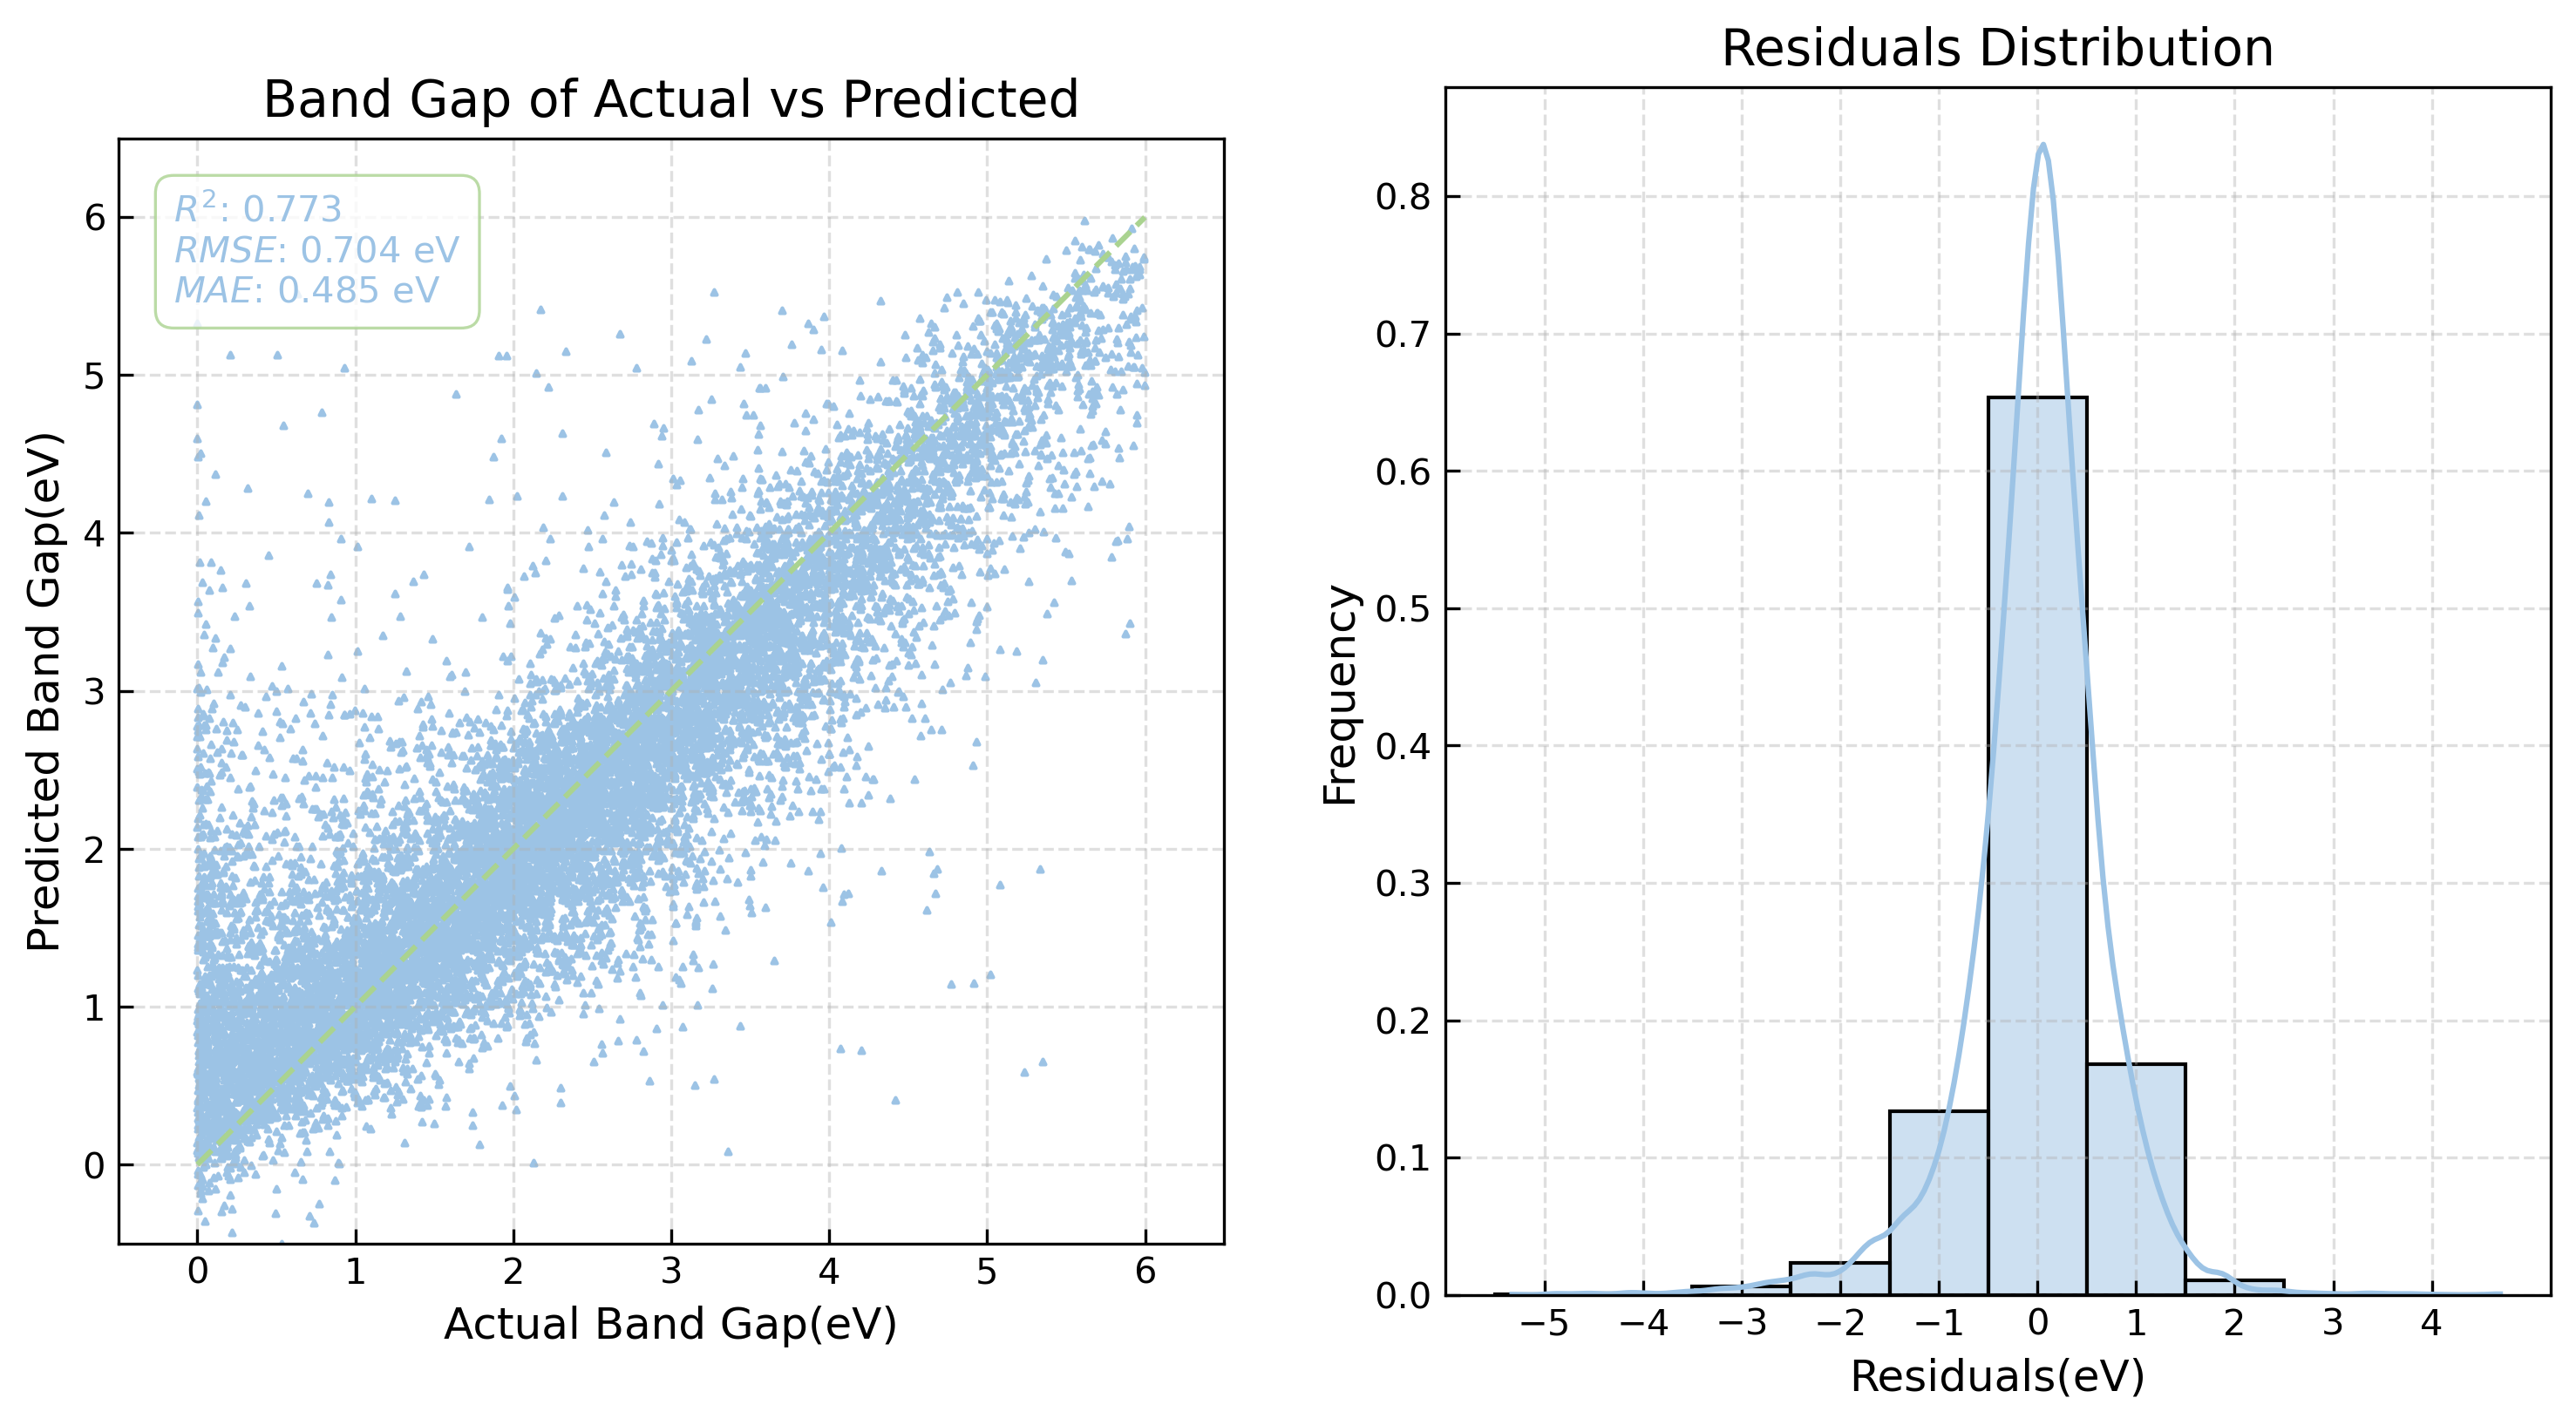


Model Evaluation Results:
Test set: R²: 0.7732 RMSE: 0.7039 MAE: 0.4851
[Test DFT -> EXP] Evaluating DFT LightGBM on EXP test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


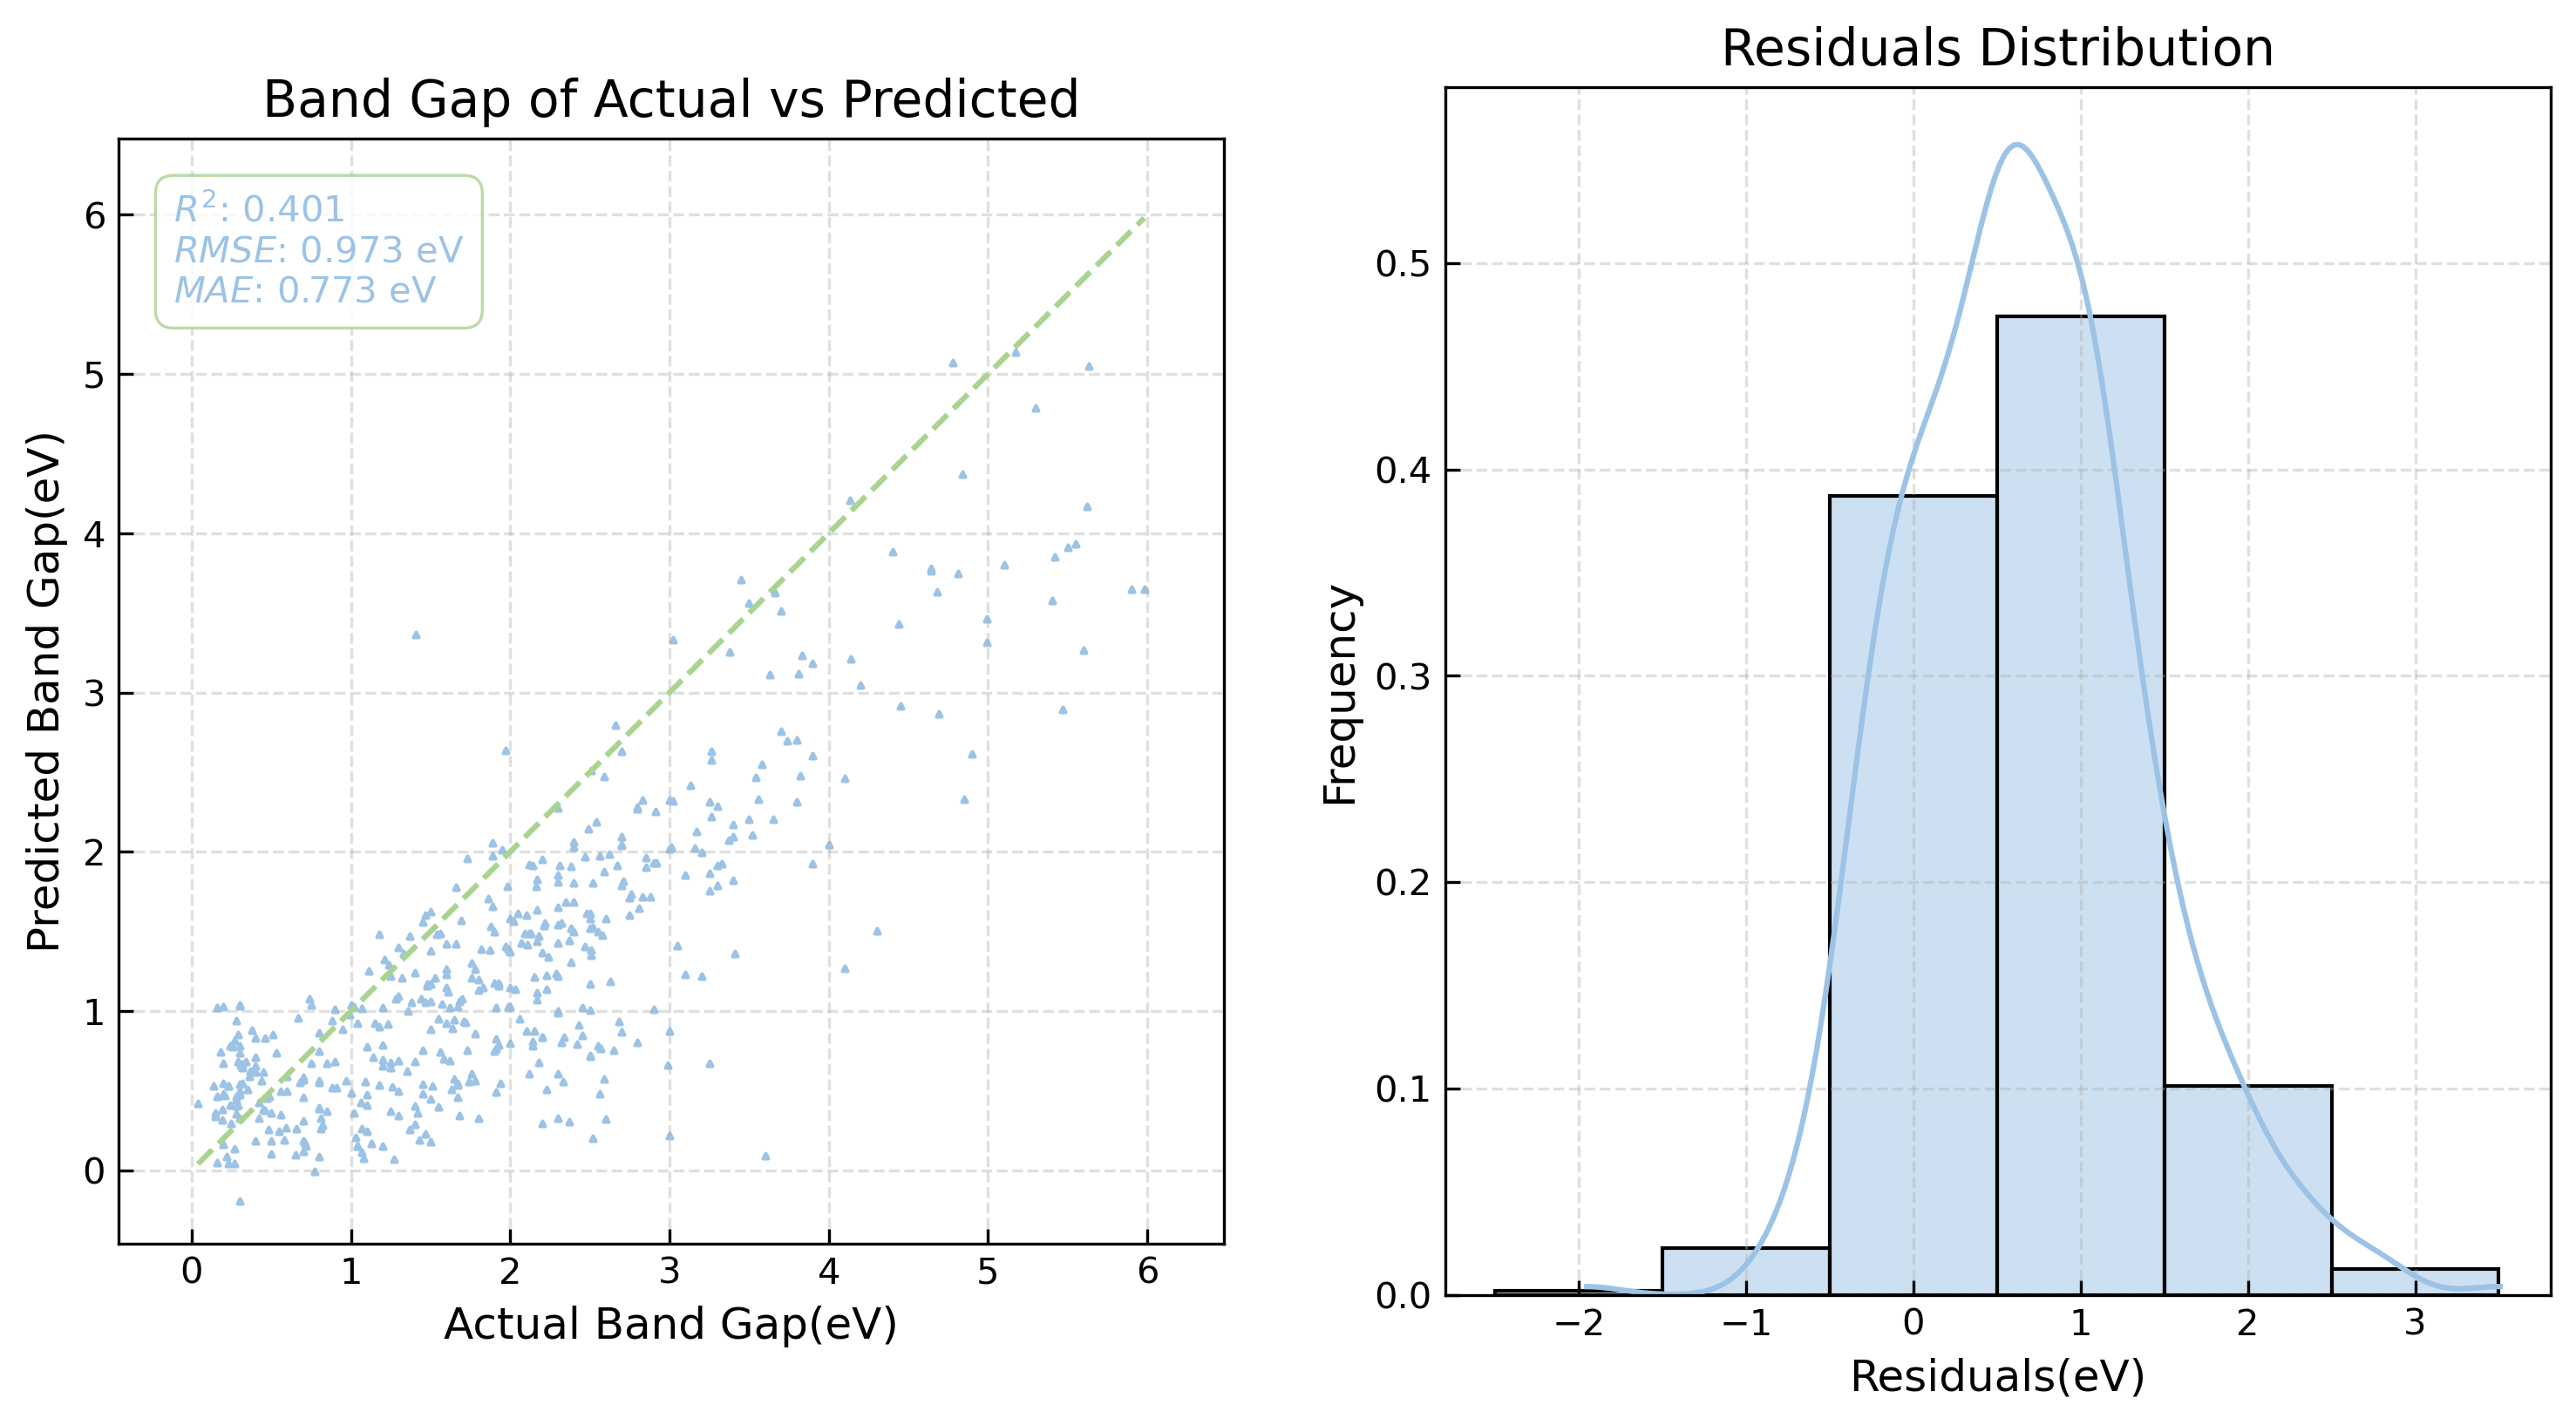


Model Evaluation Results:
Test set: R²: 0.4010 RMSE: 0.9726 MAE: 0.7726


In [9]:
# 
# Train the model with the best hyperparameters on the entire training set
lightgbm_best = LGBMRegressor(learning_rate=0.2, max_depth=-1, n_estimators=500,
    objective='regression',
    random_state=RANDOM_SEED,
    n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(lightgbm_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test DFT -> EXP] Evaluating DFT {MODEL_NAME} on EXP test set:")
metrics = dft_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [10]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,LightGBM,Train,dft,dft,0.902446,0.461210,0.329190
1,LightGBM,Test,dft,dft,0.773200,0.703937,0.485094
2,LightGBM,Test,dft,exp,0.400990,0.972617,0.772645


### EXP Model

In [ ]:
# using grid search to find the best hyperparameters for the dft model
print(f"['EXP {MODEL_NAME}'] HP optimazation begin...")
# create a pipeline with a scaler and the LightGBM model
lgbm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm',  LGBMRegressor(objective='regression', metric='rmse', random_state=RANDOM_SEED,
        n_jobs=-1, verbose=0))
])
# define the parameter grid for the LightGBM model(total 1728 combinations)
# n_iter=48, runtime=
param_grid = {
    'lgbm__n_estimators': [200, 300, 500],
    'lgbm__max_depth': [-1, 5, 7, 9],
    'lgbm__learning_rate': [0.05, 0.1, 0.2, 0.3],
    # 'lgbm__reg_alpha': [0, 0.1, 0.3],
    # 'lgbm__reg_lambda': [0, 0.1, 0.3],
    # 'lgbm__subsample': [0.7, 1.0],
    # 'lgbm__colsample_bytree': [0.7, 1.0]
}
# create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) 
# create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=lgbm_pipe, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kf, 
    n_jobs=-1, 
    verbose=True,
    return_train_score=True)

# fit the model to the training data
grid_search.fit(exp_train_X, exp_train_y)

In [ ]:
# get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validation RMSE: {best_score:.4f}")

# create a DataFrame to store the results
results = pd.DataFrame(grid_search.cv_results_)
results['test_rmse'] = np.sqrt(-results['mean_test_score'])
results['train_rmse'] = np.sqrt(-results['mean_train_score'])
# sort the results by test RMSE
results_sorted = results.sort_values('test_rmse')
results_sorted = results_sorted[['rank_test_score', 'param_lgbm__learning_rate', 
                                 'param_lgbm__max_depth', 'param_lgbm__n_estimators', 'train_rmse', 'test_rmse']]

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
results_sorted.to_csv(os.path.join(hp_path, 'exp_hp_results.csv'), index=False)
results_sorted.head()

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500}
Best Cross-Validation RMSE: 0.5672


,rank_test_score,param_learning_rate,param_max_depth,param_n_estimators,train_rmse,test_rmse
9,1,0.05,-1,500,0.075180,0.567245
15,2,0.05,8,500,0.119347,0.568544
8,3,0.05,-1,200,0.195747,0.571347
16,4,0.10,-1,200,0.099486,0.572472
17,5,0.10,-1,500,0.026757,0.572757


### Overfitting check

####################################################################################################
[EXP - LightGBM] Training LightGBM on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.1s
Model training completed!
[Train_error] Evaluating EXP LightGBM on EXP train set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


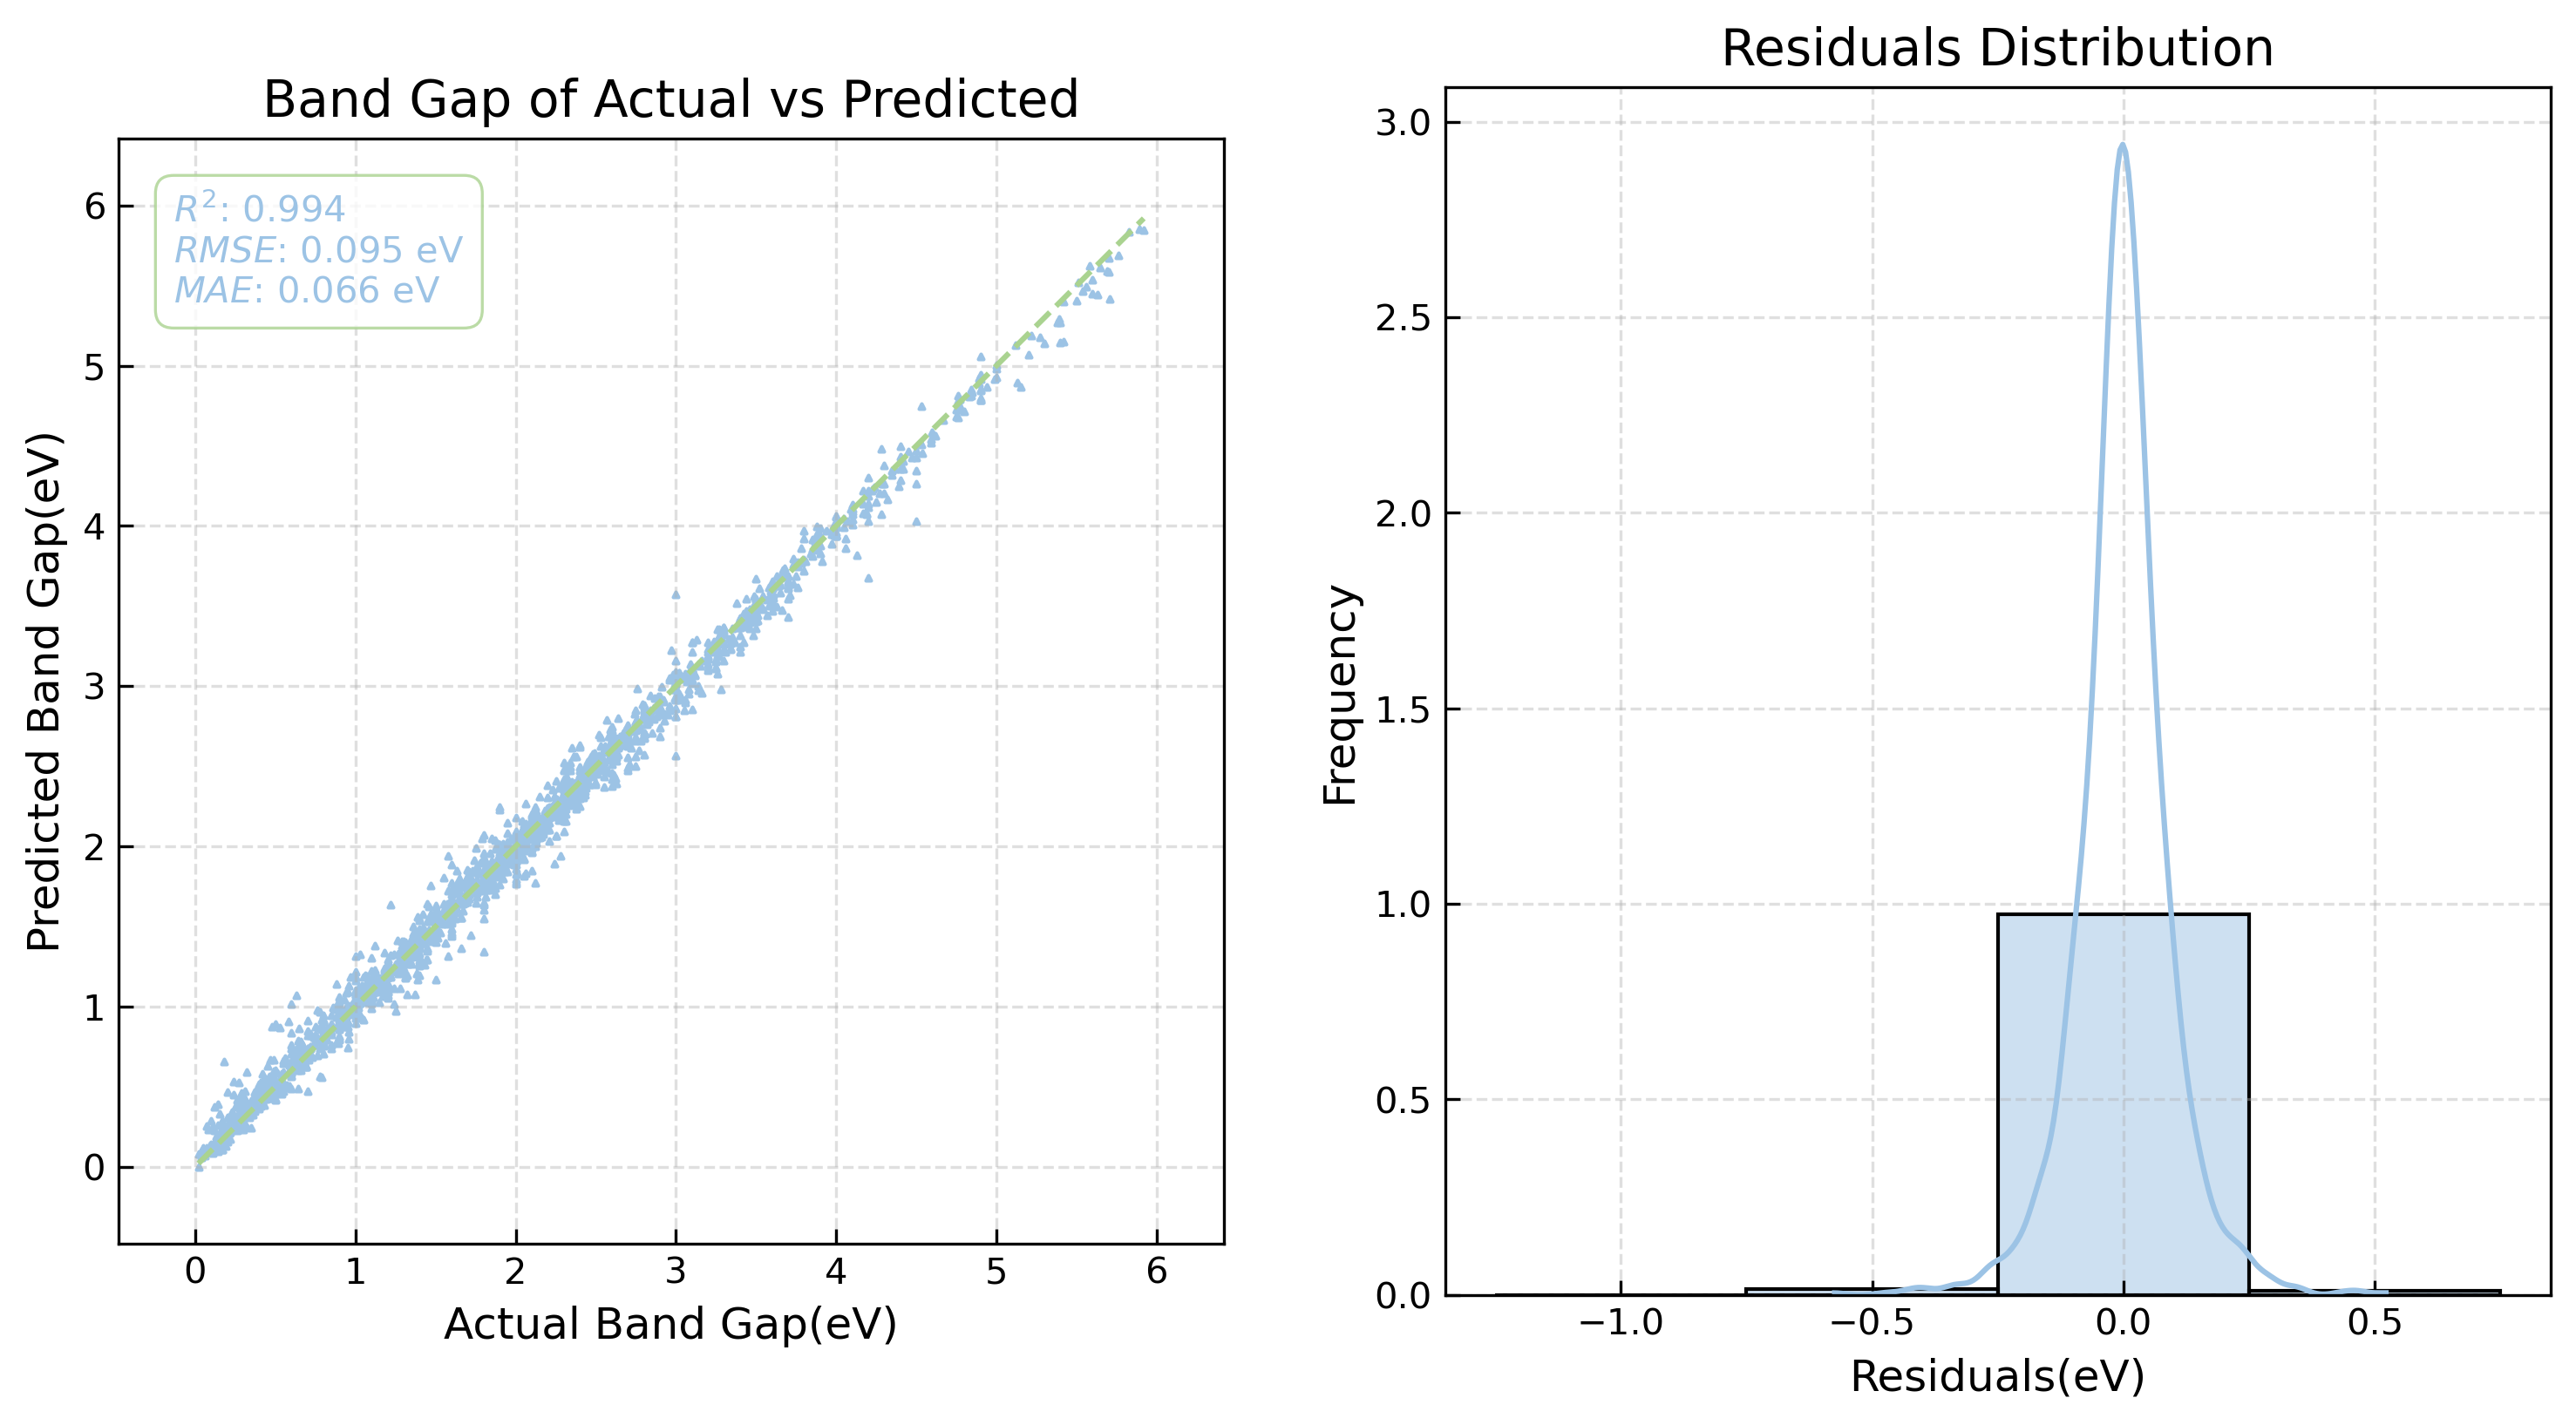


Model Evaluation Results:
Test set: R²: 0.9939 RMSE: 0.0945 MAE: 0.0660
[Test EXP -> EXP] Evaluating EXP LightGBM on EXP test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


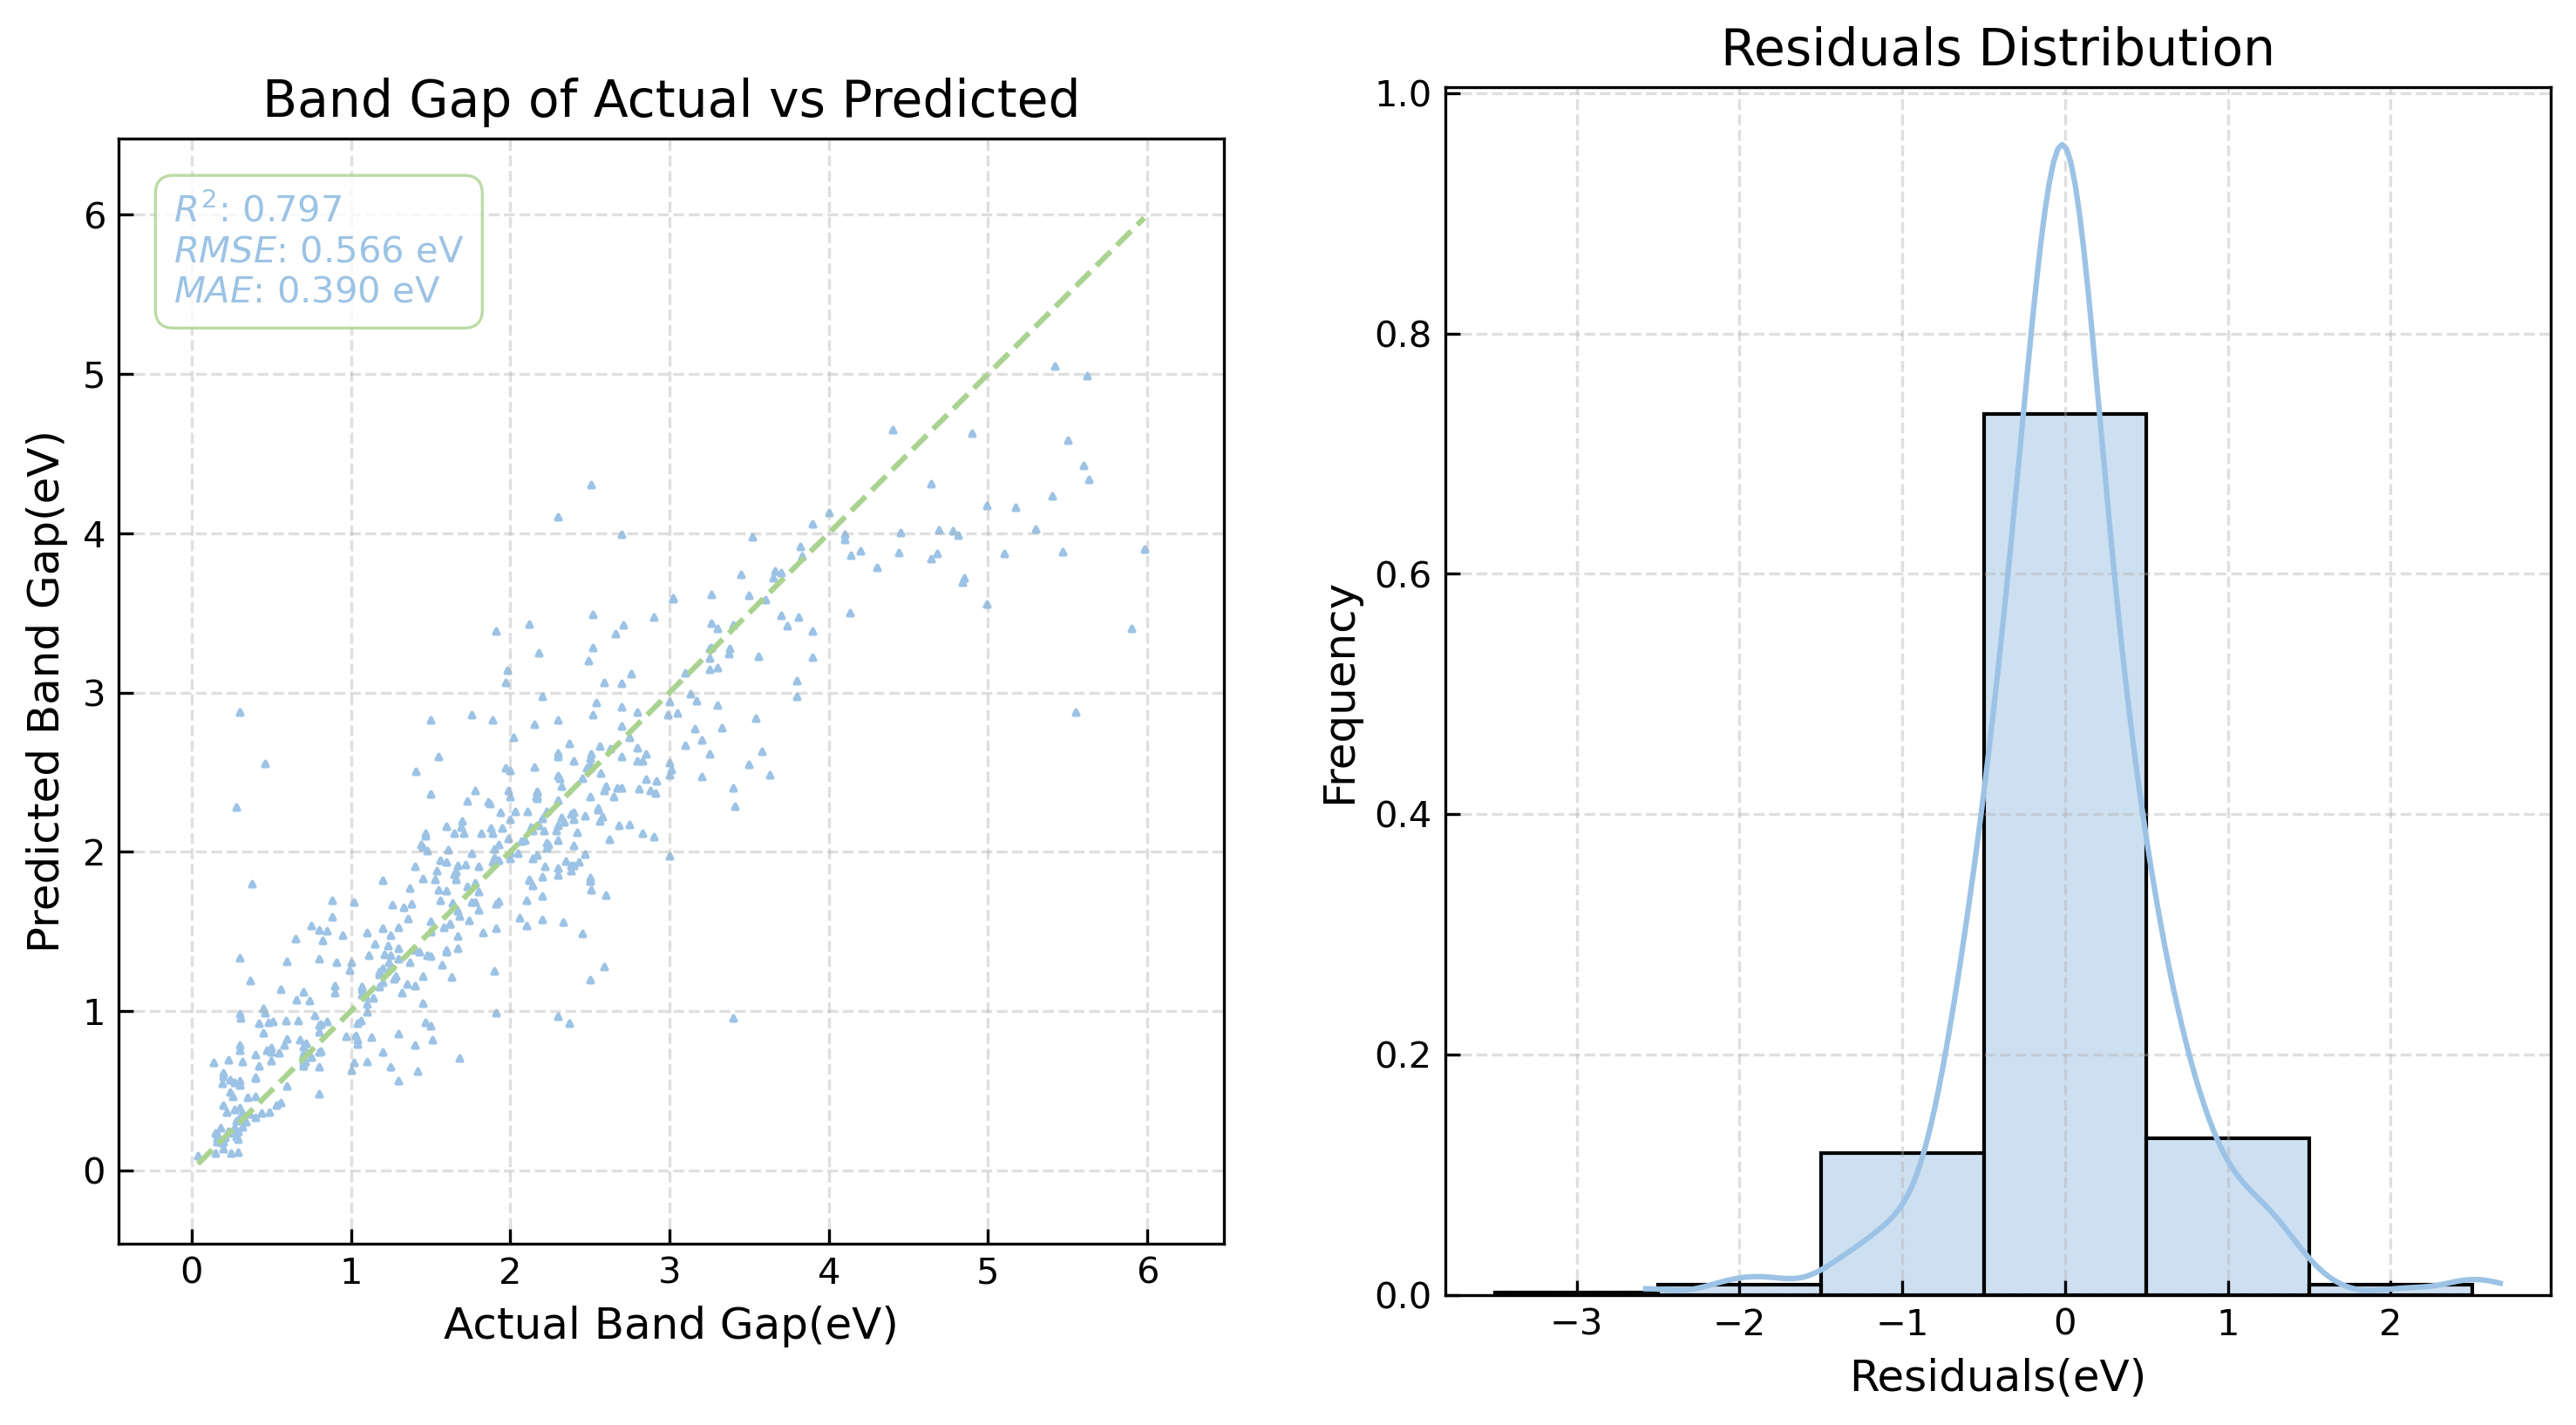


Model Evaluation Results:
Test set: R²: 0.7973 RMSE: 0.5658 MAE: 0.3898
[Test EXP -> DFT] Evaluating EXP LightGBM on DFT test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


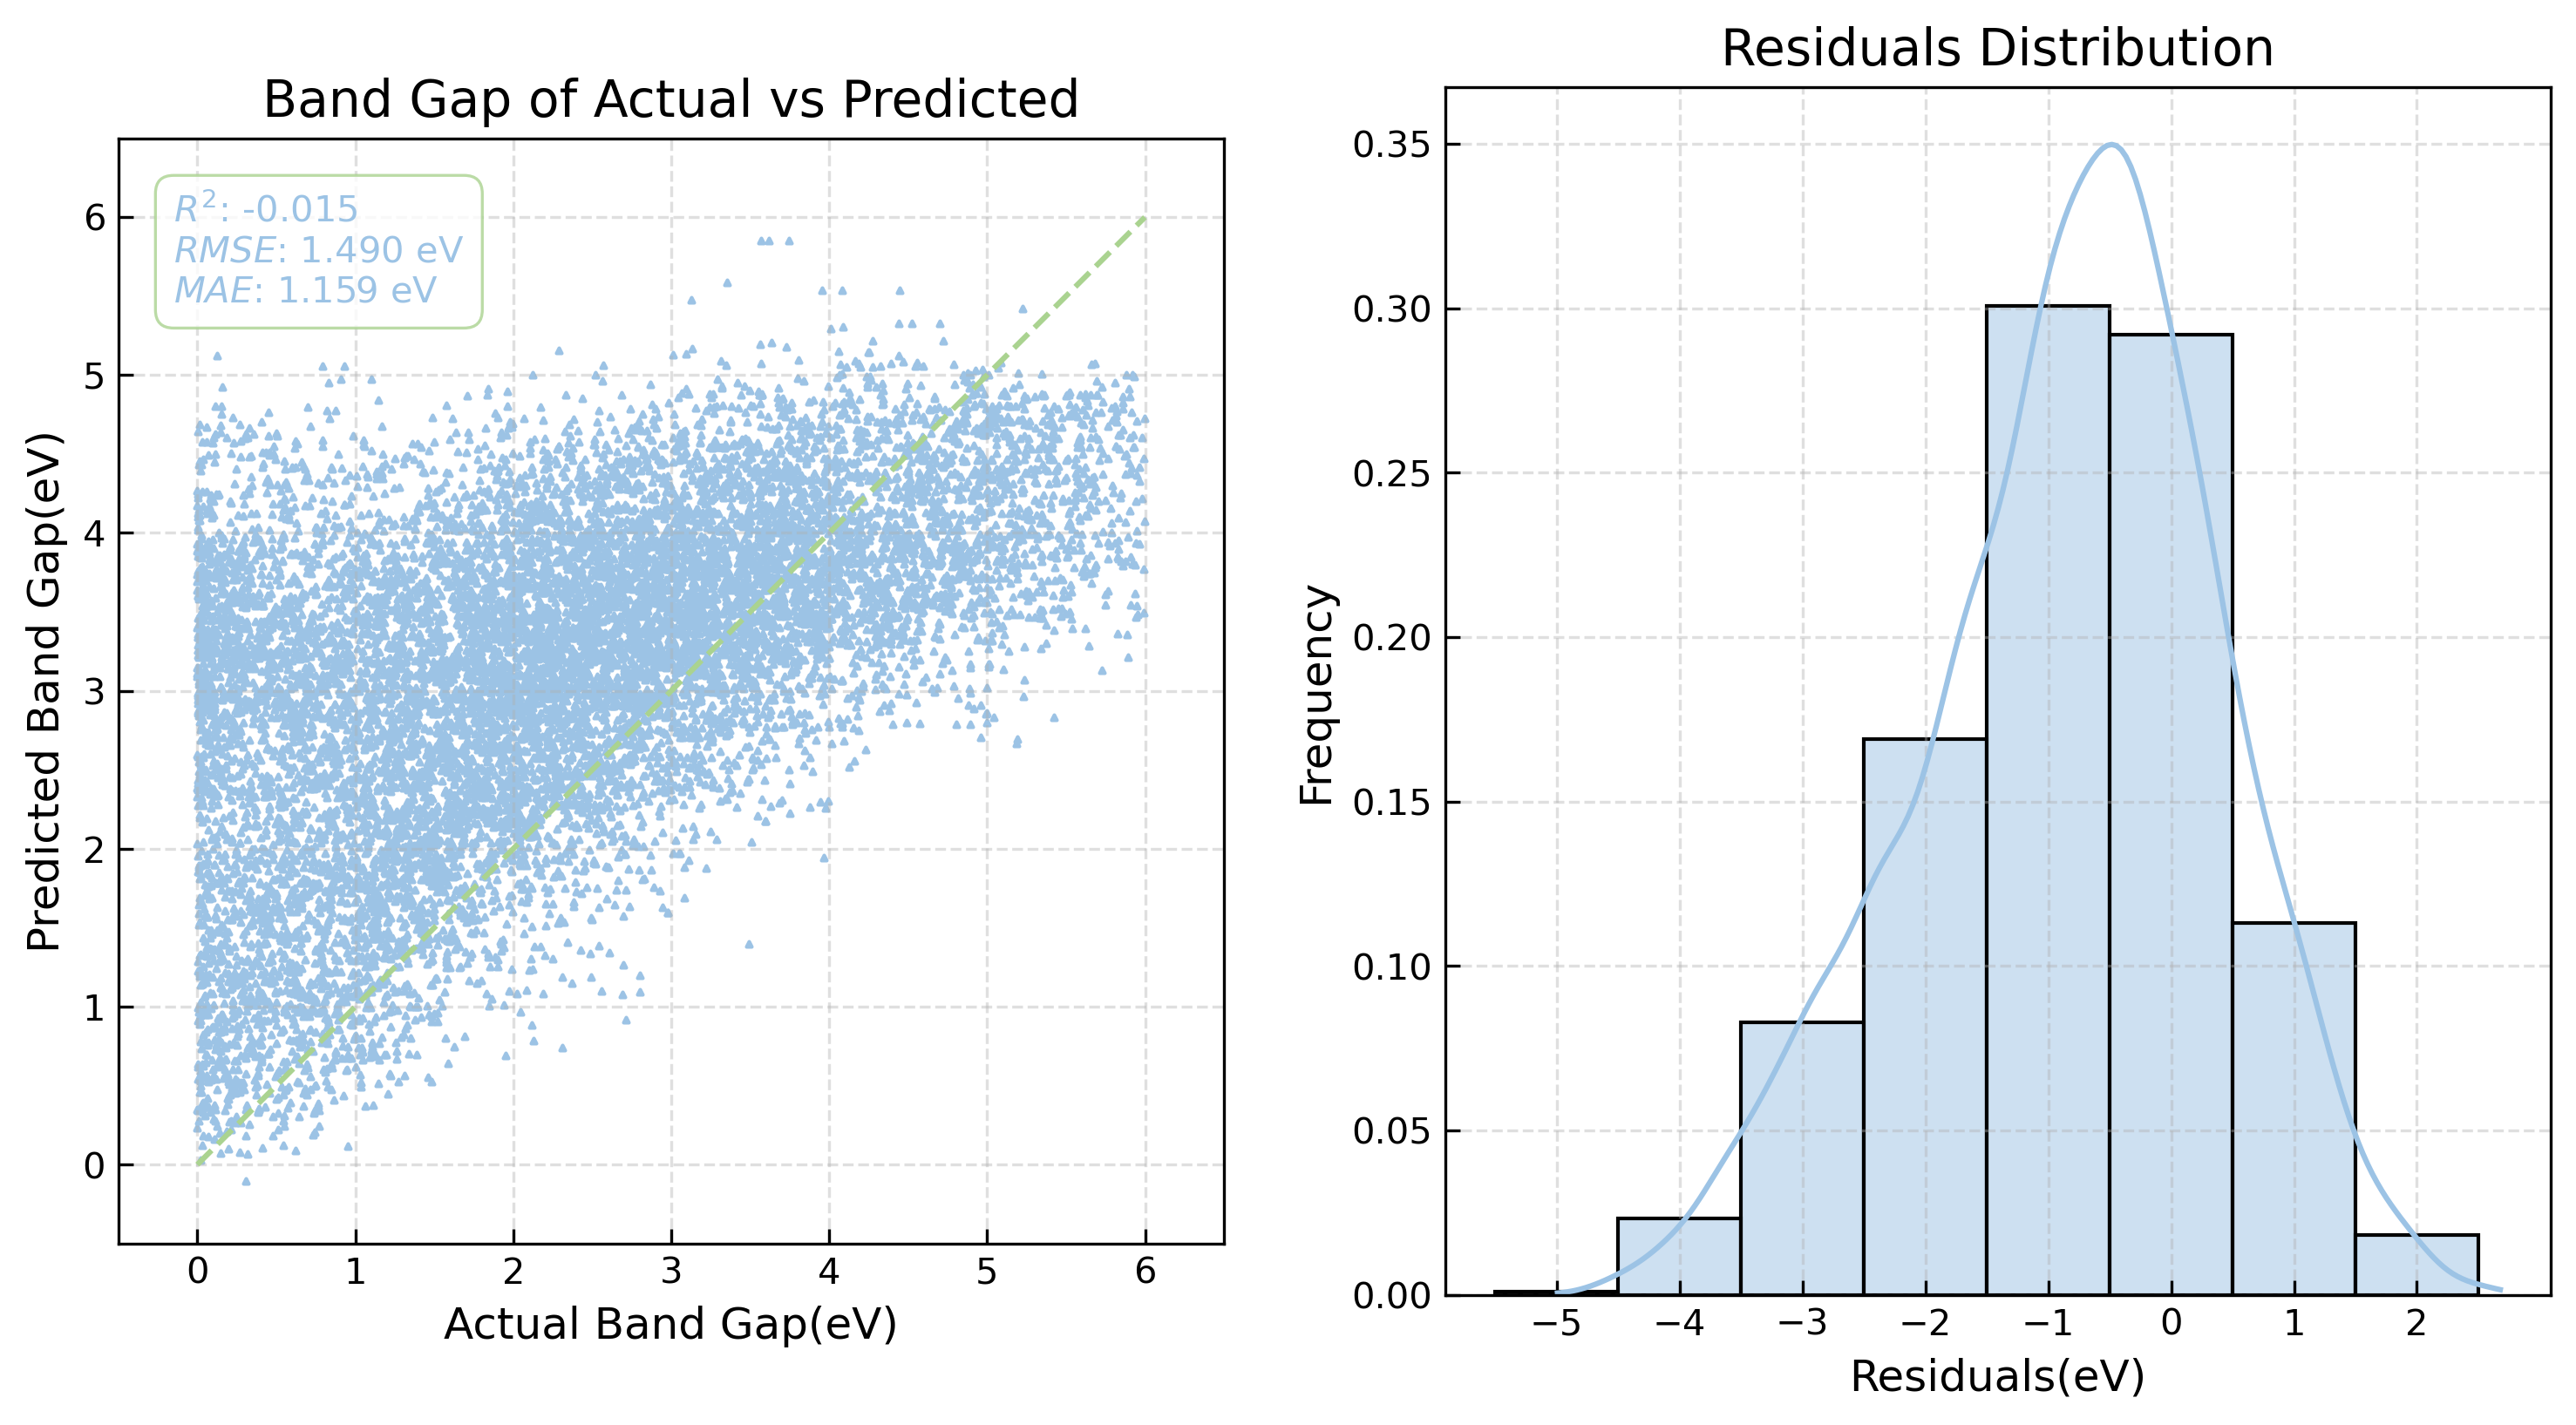


Model Evaluation Results:
Test set: R²: -0.0154 RMSE: 1.4895 MAE: 1.1594


In [18]:
# 
# Train the model with the best hyperparameters on the entire training set
lightgbm_best = LGBMRegressor(learning_rate=0.05, max_depth=-1, n_estimators=500,
    objective='regression',
    random_state=RANDOM_SEED,
    n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[EXP - {MODEL_NAME}] Training {MODEL_NAME} on EXP data:")
print("-" * 100)

exp_model = SingleModel(clone(lightgbm_best), random_state=RANDOM_SEED)
exp_model.train(exp_train_X, exp_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating EXP {MODEL_NAME} on EXP train set:")
metrics = exp_model.evaluate(exp_train_X, exp_train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test EXP -> EXP] Evaluating EXP {MODEL_NAME} on EXP test set:")

metrics = exp_model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test EXP -> DFT] Evaluating EXP {MODEL_NAME} on DFT test set:")
metrics = exp_model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'exp',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

In [19]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,LightGBM,Train,exp,exp,0.993934,0.094504,0.065997
1,LightGBM,Test,exp,exp,0.797301,0.565784,0.389756
2,LightGBM,Test,exp,dft,-0.015448,1.489503,1.159438
